# Time series modeling with ARIMA
Instead of deep learning, we can try using classical statistical methods for time series forecasting such as ARIMA (Autoregressive Integrated Moving Average).

In [95]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

# Data input and preprocessing

# Reads in currency exchange rate data
filename='DEXUSEU' # Filename
dataset = pd.read_csv('data/'+filename+'.csv') # Reads in CSV file
exchangevalues = dataset.iloc[:, 1:2] # Selects columns

# Replaces missing data (represented by '.') with zeros ('0')
mask=exchangevalues=='.'
exchangevalues[mask] = '0'

# Reformats columns into floats
exchangevalues=np.array(exchangevalues)
exchangevalues=np.matrix([float(x) for x in exchangevalues])
exchangevalues=exchangevalues.transpose()

# Fills in missing and outlier values by taking average between adjacent timesteps
mean,std=np.mean(exchangevalues),np.std(exchangevalues) # Computes mean and std
indices = [i for i ,x in enumerate(exchangevalues) if x<mean-2.5*std] # Finds indices of zero and outlier values
for i in indices:
    # First, checks the initial and final elements of the list
    # If any of these are zero, set them to be equal to their adjacent values
    if i==0:
        exchangevalues[i] = exchangevalues[i+1]
    elif i==len(exchangevalues)-1:
        exchangevalues[i] = exchangevalues[i-1]
    
    # For the rest of the elements, set them to be the average of their adjacent values
    exchangevalues[i] = 0.5*(exchangevalues[i+1]+exchangevalues[i-1]) 


# Formats inputs so that it's readable by the ARIMA model 
rate = exchangevalues.transpose()
rate = rate.tolist()[0]
table = {"day": range(0,len(rate)), "ex_rate": rate}

data = pd.DataFrame(table)
data.set_index("day", inplace=True)

# Training/test set split
N_test = 300 # Length of test set
y_train = data[:-N_test]
y_test = data[-N_test:]
x_values = range(0,len(y_train))

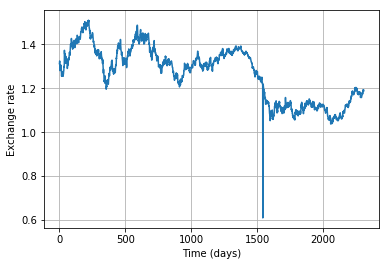

In [96]:
plt.plot(x_values,y_train)
plt.xlabel('Time (days)')
plt.ylabel('Exchange rate')
plt.grid(True)

Now we set the parameters for the ARIMA model and fitting it. Basically, I picked these parameters by looking at the residual plots below.

In [97]:
from statsmodels.tsa.arima_model import ARIMA

# Parameters for ARIMA model
p = 5 # Lag order
d = 1 # Degree of differencing
q = 0 # Moving average order

# Fits the ARIMA model
ARIMA_model = ARIMA(y_train, order=(p,d,q))
model_fit = ARIMA_model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:              D.ex_rate   No. Observations:                 2309
Model:                 ARIMA(5, 1, 0)   Log Likelihood                6250.406
Method:                       css-mle   S.D. of innovations              0.016
Date:                Mon, 15 Jul 2019   AIC                         -12486.811
Time:                        21:28:55   BIC                         -12446.599
Sample:                             1   HQIC                        -12472.153
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -5.254e-05      0.000     -0.298      0.766      -0.000       0.000
ar.L1.D.ex_rate    -0.2251      0.021    -10.831      0.000      -0.266      -0.184
ar.L2.D.ex_rate    -0.3536      

Let's have a look at the residual errors to evaluate out model.

                 0
count  2309.000000
mean     -0.000001
std       0.016152
min      -0.612735
25%      -0.004480
50%       0.000016
75%       0.004871
max       0.166311


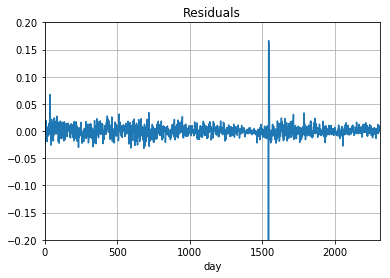

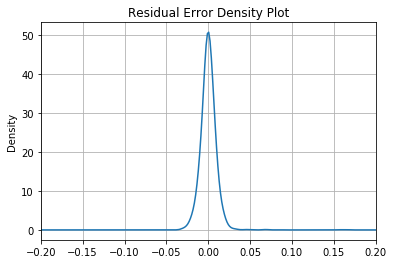

In [98]:
# Plots residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(legend=False, ylim=[-0.2,0.2], grid=True, title='Residuals')
#plt.show()
residuals.plot(kind='kde', legend=False, grid=True,xlim=[-0.2,0.2], title='Residual Error Density Plot')
#plt.show()
print(residuals.describe())

The residuals are centered around a mean of 0, which shows that out model doesn't have any substiantial bias. The ARIMA model even managed to capture that huge crash in the exchange rate, so it seems to be nearly as good as the RNN model in that regard.

# ARIMA forecasting
Now let's try to use this model to make prediction on our train set. Here we'll use a rolling forecast since the model requires obervations in the previous time steps to predict the next one.

In [112]:
history = y_train.ex_rate.tolist()
predictions = list()

# This refits the ARIMA model after every timestep, which is a bit crude and inefficent but it works for now...
for t in range(len(y_test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = y_test.ex_rate.tolist()[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))

Test MSE: 0.001


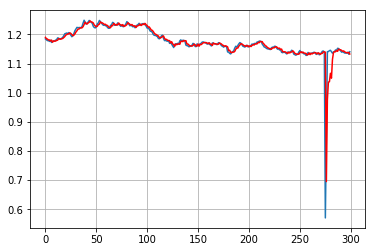

In [125]:
from sklearn.metrics import mean_squared_error

# Calcualtes MSE
error = mean_squared_error(y_test['ex_rate'].tolist(), predictions)
#print(predictions)
print('Test MSE: %.3f' % error)

# Plots test set vs. predictions
plt.plot(y_test['ex_rate'].tolist())
plt.plot(predictions, color='red')
plt.grid(True)